## Import Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import f_oneway

## Load Dataset

In [22]:
data_set = pd.read_csv("student_spending.csv")
data_set.shape

(1000, 18)

## Data Cleaning & Preprocessing

In [24]:
# Check for missing values
print(data_set.isnull().sum())

Unnamed: 0                  0
age                         0
gender                      0
year_in_school              0
major                       0
monthly_income              0
financial_aid               0
tuition                     0
housing                     0
food                        0
transportation              0
books_supplies              0
entertainment               0
personal_care               0
technology                  0
health_wellness             0
miscellaneous               0
preferred_payment_method    0
dtype: int64


In [25]:
# Encode categorical variables
categorical_cols = ['gender', 'year_in_school', 'major', 'preferred_payment_method']
for col in categorical_cols:
    data_set[col] = data_set[col].astype('category')

# Optional: Label encode for clustering/ML
le = LabelEncoder()
for col in categorical_cols:
    data_set[col + '_enc'] = le.fit_transform(data_set[col])


## Exploratory Data Analysis (EDA)

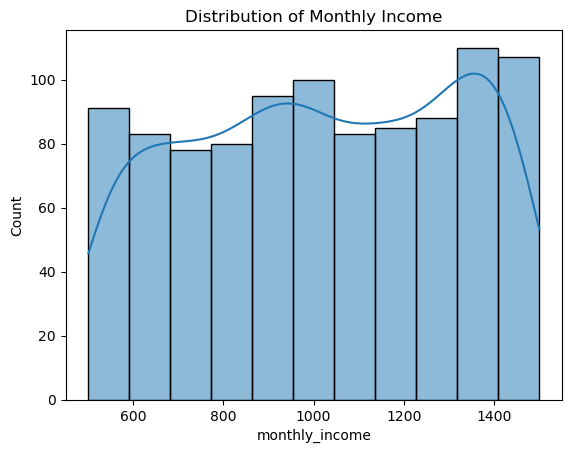

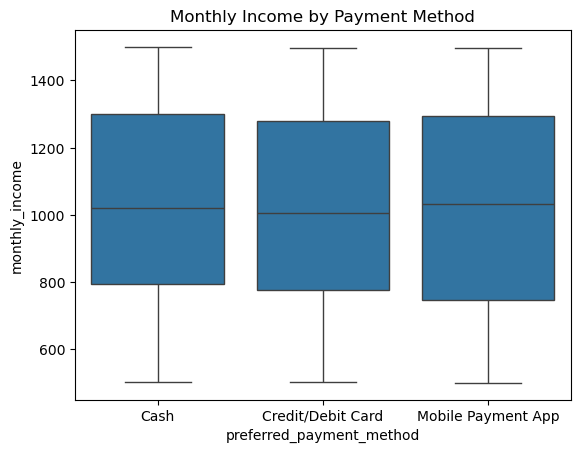

In [27]:
# Distribution of a continuous variable
sns.histplot(data_set['monthly_income'], kde=True)
plt.title('Distribution of Monthly Income')
plt.show()

# Spending by payment method
sns.boxplot(x='preferred_payment_method', y='monthly_income', data=data_set)
plt.title('Monthly Income by Payment Method')
plt.show()


## Correlation Matrix (Continuous Variables)

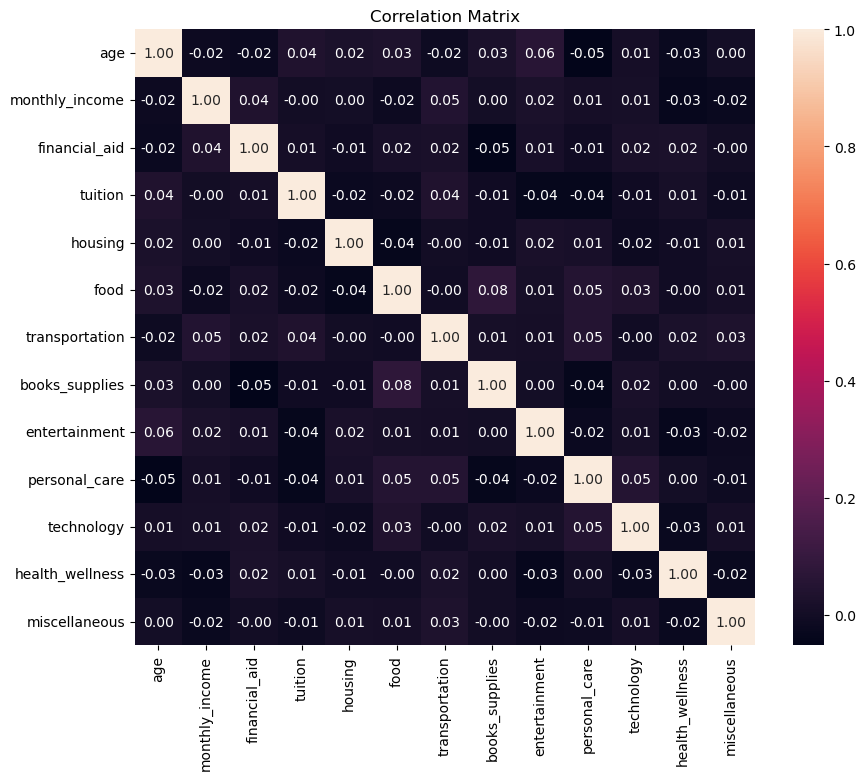

In [29]:
continuous_vars = ['age', 'monthly_income', 'financial_aid', 'tuition', 'housing', 'food',
                   'transportation', 'books_supplies', 'entertainment', 'personal_care',
                   'technology', 'health_wellness', 'miscellaneous']
corr = data_set[continuous_vars].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Principal Component Analysis (PCA)

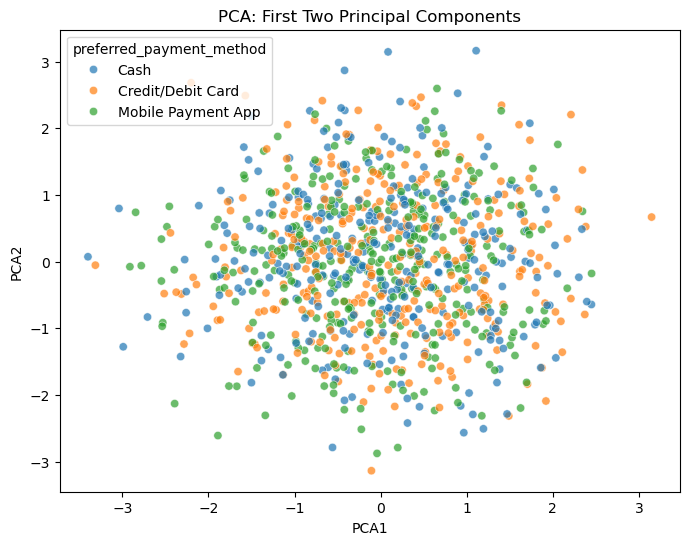

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_set[continuous_vars])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data_set['PCA1'] = pca_result[:,0]
data_set['PCA2'] = pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='preferred_payment_method', data=data_set, alpha=0.7)
plt.title('PCA: First Two Principal Components')
plt.show()

In [73]:
# Get PCA Loading Matrix
loadings = pca.components_.T  # Shape: (n_features, n_components)

# Use all continuous variables/features that PCA was fit on
used_features = data_set[continuous_vars].columns.tolist()  # Make sure this matches PCA input features

# Number of PCA components
num_components = loadings.shape[1]

# Create column names dynamically based on number of components
column_names = [f'PCA{i+1}' for i in range(num_components)]

# Create DataFrame with correct shape and labels
loading_df = pd.DataFrame(
    loadings,
    index=used_features,
    columns=column_names
)

# Print Loading Matrix
print("PCA Loading Matrix:")
print(loading_df)


PCA Loading Matrix:
                     PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
age              0.535862 -0.161001  0.134967  0.177536  0.074008  0.024598   
monthly_income  -0.118837  0.144193  0.525543  0.253109  0.003315 -0.126972   
financial_aid   -0.242885  0.093875  0.290849  0.299675 -0.339529  0.248573   
tuition         -0.046582 -0.274441 -0.083585  0.578629  0.126402  0.206166   
housing          0.024119 -0.151127  0.306689 -0.355255  0.308438 -0.320924   
food             0.296018  0.509504 -0.240334  0.153931 -0.095249 -0.031080   
transportation  -0.241164  0.204615  0.175421  0.413364  0.537391 -0.217814   
books_supplies   0.427376  0.216247 -0.259714  0.214631  0.167345 -0.332422   
entertainment    0.350739  0.056701  0.502786 -0.008024 -0.149395 -0.199900   
personal_care   -0.310046  0.523503 -0.004974 -0.234056  0.107421 -0.130529   
technology       0.092989  0.463003  0.075812  0.003541 -0.095759  0.375762   
health_wellness -0.281794 -0.077

In [41]:
# Variance explained by each component

pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_

# Print each component's explained variance
for i, var in enumerate(explained_var, start=1):
    print(f"PCA{i} explains {var:.2%} of the variance")

PCA1 explains 8.77% of the variance
PCA2 explains 8.64% of the variance
PCA3 explains 8.37% of the variance
PCA4 explains 8.23% of the variance
PCA5 explains 7.99% of the variance
PCA6 explains 7.81% of the variance


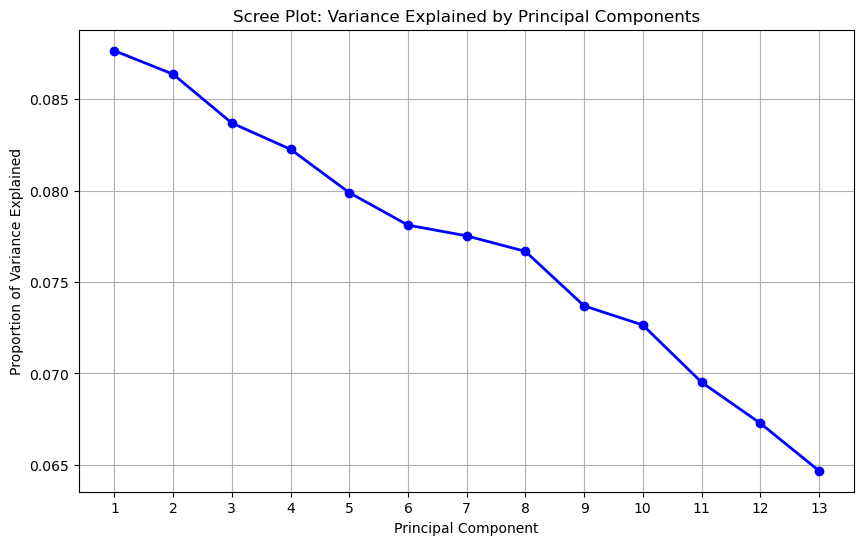

In [43]:
# Create scree plot

# Fit PCA with all components
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_,
    'o-',
    linewidth=2,
    color='blue'
)
plt.title('Scree Plot: Variance Explained by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.xticks(range(1, len(continuous_vars) + 1))
plt.grid(True)
plt.show()

## K-Means Clustering

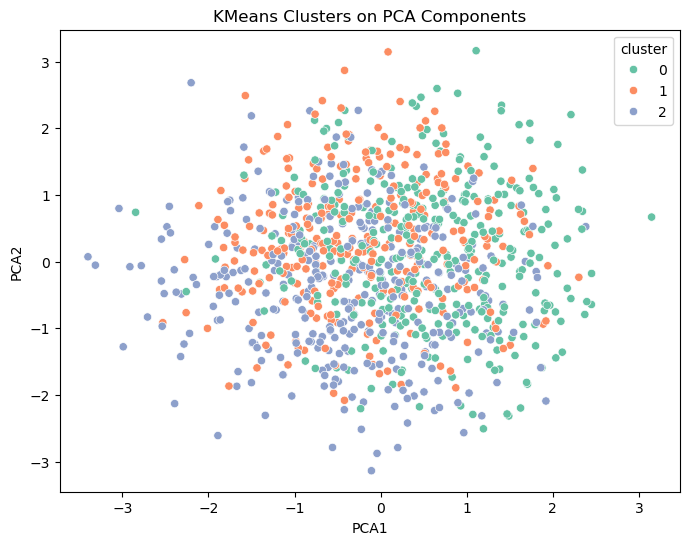

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42)
data_set['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=data_set, palette='Set2')
plt.title('KMeans Clusters on PCA Components')
plt.show()

## ANOVA

In [47]:
# Compare monthly income across payment methods
groups = [data_set[data_set['preferred_payment_method'] == method]['monthly_income'] for method in data_set['preferred_payment_method'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

ANOVA F-statistic: 0.06, p-value: 0.9386


## MANOVA

In [49]:
from statsmodels.multivariate.manova import MANOVA

# Define spending variables (dependent variables)
dependent_vars = [
    'tuition', 'housing', 'food', 'transportation',
    'books_supplies', 'entertainment', 'personal_care',
    'technology', 'health_wellness', 'miscellaneous'
]

# Convert payment method to categorical
data_set['preferred_payment_method'] = data_set['preferred_payment_method'].astype('category')

# Perform MANOVA
maov = MANOVA.from_formula(
    f"{' + '.join(dependent_vars)} ~ preferred_payment_method", 
    data=data_set
)

# Print results
print(maov.mv_test())

                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
       Intercept         Value   Num DF  Den DF   F Value  Pr > F
-----------------------------------------------------------------
          Wilks' lambda  0.0323 10.0000 988.0000 2958.7641 0.0000
         Pillai's trace  0.9677 10.0000 988.0000 2958.7641 0.0000
 Hotelling-Lawley trace 29.9470 10.0000 988.0000 2958.7641 0.0000
    Roy's greatest root 29.9470 10.0000 988.0000 2958.7641 0.0000
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
 preferred_payment_method Value   Num DF   Den DF  F Value Pr > F
-----------------------------------------------------------------
            Wilks' lambda 0.9738 20.0000 1976.0000  1.3190 0.1554
           Pillai's trace 0.02

## Linear Discriminant Analysis (LDA)

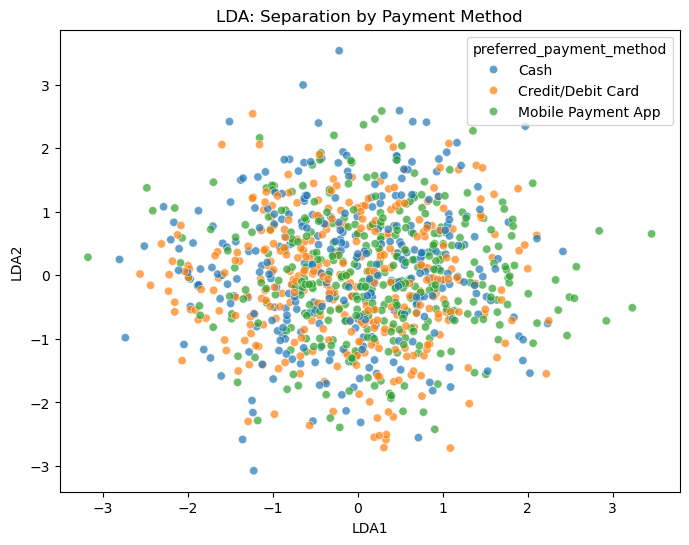

In [55]:
lda = LDA(n_components=2)
# Use only numeric columns + encoded categorical as features
feature_cols = continuous_vars + [col + '_enc' for col in categorical_cols]
X_lda = data_set[feature_cols]
y_lda = data_set['preferred_payment_method_enc']
lda_result = lda.fit_transform(X_lda, y_lda)
data_set['LDA1'] = lda_result[:,0]
data_set['LDA2'] = lda_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='LDA1', y='LDA2', hue='preferred_payment_method', data=data_set, alpha=0.7)
plt.title('LDA: Separation by Payment Method')
plt.show()

## Canonical correlation

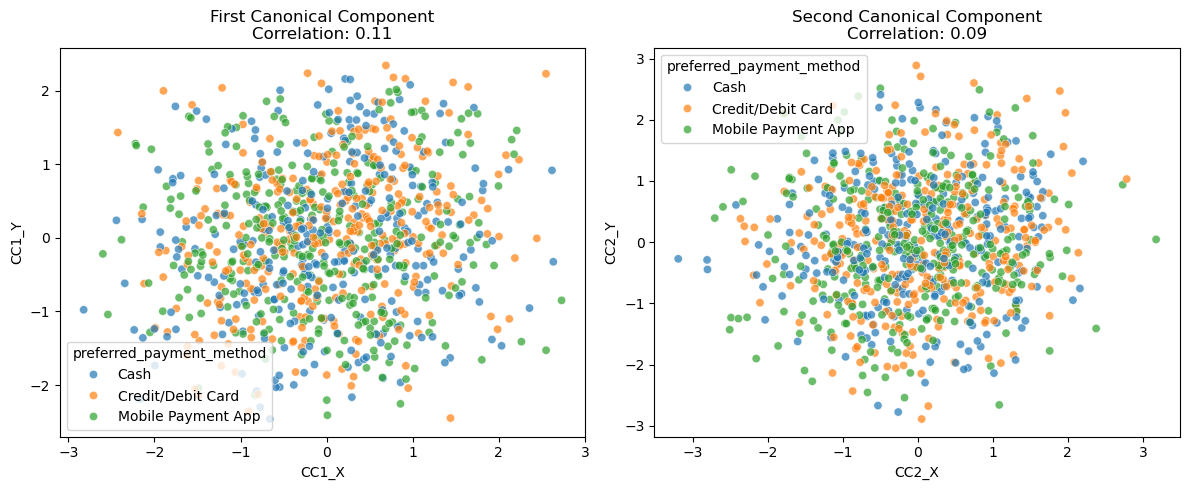

                    X_Loadings  Y_Loadings
tuition               0.255179         NaN
housing               0.608155         NaN
food                  0.143236         NaN
transportation       -0.340845         NaN
books_supplies        0.498297         NaN
entertainment         0.427272         NaN
age                        NaN    0.648948
monthly_income             NaN   -0.036764
financial_aid              NaN   -0.219450
gender_enc                 NaN    0.113555
year_in_school_enc         NaN   -0.720145


In [61]:
from sklearn.cross_decomposition import CCA

# Split into two views (X and Y)
# View 1: Spending categories
X = data_set[['tuition', 'housing', 'food', 'transportation', 
        'books_supplies', 'entertainment']]

# View 2: Demographic + financial features
Y = data_set[['age', 'monthly_income', 'financial_aid', 
        'gender_enc', 'year_in_school_enc']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y)

# Perform CCA
cca = CCA(n_components=2)
cca.fit(X_scaled, Y_scaled)

# Transform the data
X_c, Y_c = cca.transform(X_scaled, Y_scaled)

# Create results dataframe
cca_results = pd.DataFrame({
    'CC1_X': X_c[:, 0],
    'CC1_Y': Y_c[:, 0],
    'CC2_X': X_c[:, 1],
    'CC2_Y': Y_c[:, 1],
    'preferred_payment_method': data_set['preferred_payment_method']
})

# Visualization
plt.figure(figsize=(12, 5))

# First Canonical Component
plt.subplot(1, 2, 1)
sns.scatterplot(x='CC1_X', y='CC1_Y', hue='preferred_payment_method', 
                data=cca_results, alpha=0.7)
plt.title('First Canonical Component\nCorrelation: %.2f' % 
         np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1])

# Second Canonical Component
plt.subplot(1, 2, 2)
sns.scatterplot(x='CC2_X', y='CC2_Y', hue='preferred_payment_method', 
                data=cca_results, alpha=0.7)
plt.title('Second Canonical Component\nCorrelation: %.2f' % 
         np.corrcoef(X_c[:, 1], Y_c[:, 1])[0, 1])

plt.tight_layout()
plt.show()

# For X loadings (spending categories)
x_loadings = pd.DataFrame(
    cca.x_loadings_[:, 0],
    index=X.columns,
    columns=['X_Loadings']
)
# For Y loadings (demographic/financial features)
y_loadings = pd.DataFrame(
    cca.y_loadings_[:, 0],
    index=Y.columns,
    columns=['Y_Loadings']
)
# Combine them horizontally for comparison
loadings_combined = pd.concat([x_loadings, y_loadings], axis=0)
print(loadings_combined)


## Factor Analysis 

Bartlett's Test: χ² = 52.6, p = 0.9877
KMO Overall: 0.488


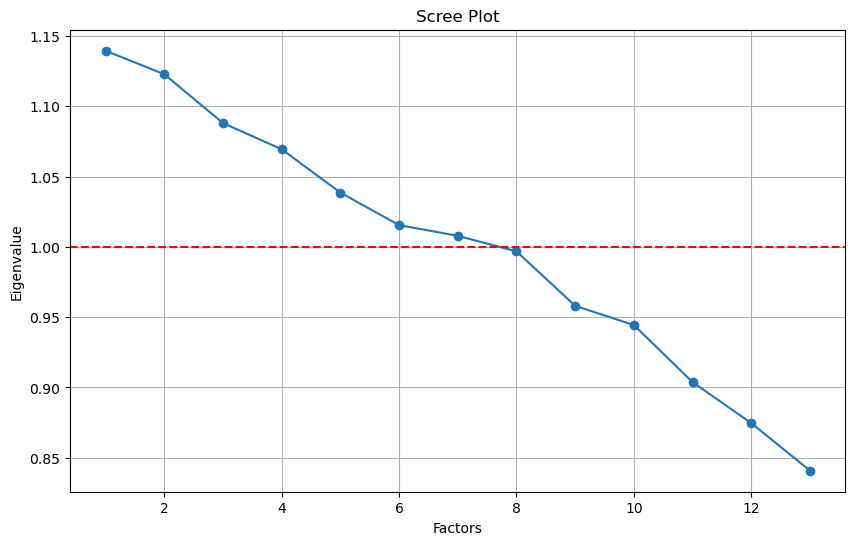


Factor Loadings:
                 Factor1  Factor2  Factor3
age                -0.05     0.12     0.04
monthly_income      0.01     0.03    -0.06
financial_aid      -0.00     0.00    -0.05
tuition            -0.04    -0.06    -0.01
housing             0.02     0.01    -0.09
food                0.04     0.14     0.30
transportation      0.05    -0.00    -0.02
books_supplies     -0.04     0.09     0.21
entertainment       0.01     0.56    -0.22
personal_care       0.99    -0.04     0.06
technology          0.05     0.06     0.08
health_wellness     0.00    -0.07    -0.00
miscellaneous      -0.01    -0.02     0.02

Variance Explained:
         SS Loadings  % of Variance  Cumulative %
Factor1     1.003320       0.077178      0.077178
Factor2     0.366186       0.028168      0.105347
Factor3     0.209370       0.016105      0.121452


In [75]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler

X = data_set[continuous_vars]
# Handle missing values
X = X.dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Adequacy Tests
# Bartlett’s Test
chi_sq, p_value = calculate_bartlett_sphericity(X)
print(f"Bartlett's Test: χ² = {chi_sq:.1f}, p = {p_value:.4f}")

# KMO Test
kmo_all, kmo_model = calculate_kmo(X)
print(f"KMO Overall: {kmo_model:.3f}")

#Determine Number of Factors
fa = FactorAnalyzer(rotation=None, impute='median')
fa.fit(X_scaled)

# Eigenvalues and Scree Plot
ev, _ = fa.get_eigenvalues()
plt.figure(figsize=(10,6))
plt.plot(range(1, X.shape[1]+1), ev, 'o-')
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

#Factor Analysis 
n_factors = 3  # Choose based on scree plot elbow
fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
fa.fit(X_scaled)

#Interpret Results
# Factor Loadings
loadings = pd.DataFrame(
    fa.loadings_,
    index=continuous_vars,
    columns=[f'Factor{i+1}' for i in range(n_factors)]
)
print("\nFactor Loadings:")
print(loadings.round(2))

# Variance Explained
variance = fa.get_factor_variance()
print("\nVariance Explained:")
print(pd.DataFrame({
    'SS Loadings': variance[0],
    '% of Variance': variance[1],
    'Cumulative %': variance[2]
}, index=[f'Factor{i+1}' for i in range(n_factors)]))